## Topic Modeling with Projection Method


In [ ]:
%%capture
import numpy  as np
import pandas as pd
import os
import hdbscan
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import seaborn as sns
import sklearn.datasets as data
import regex as re
import torch
import json
import matplotlib
import math
import faiss
from numpy.linalg import svd, norm
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from scipy import optimize
from scipy.sparse import csr_matrix
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from wordcloud import WordCloud
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
from pandas.tseries.holiday import USFederalHolidayCalendar as usholidaycalendar
from torch.nn import functional as F
from torch.utils.data import Dataset, IterableDataset, DataLoader
from cycler import cycler
from datetime import datetime
from Textual_Factors.utilities import Dataloader, SimilarityMeasure, Get_PCA_Embds, HashTable, LSH, Unitvec
from math import log10, floor
from bokeh.plotting import figure, output_file, save
from bokeh.io import output_notebook, show, export_png
from bokeh.models import LinearColorMapper, HoverTool, Range1d
tqdm().pandas()

root_dir  = 'C:/Users/Stefa/Documents/Uni/Projektassistenz/Paper III GUIDED TOPIC CLUSTERING/'
data_path = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Paper III GUIDED TOPIC CLUSTERING/Data/"
#path      = "C:/Users/Stefa/Documents/Sentiment Analysis Files/FX/"

style = {
  "lines.linewidth": 2.0,
  "axes.edgecolor": "#bcbcbc",
  "patch.linewidth": 0.5,
  "legend.fancybox": True,
  "axes.prop_cycle": cycler('color', ["#348ABD","#A60628","#7A68A6","#467821","#CF4457","#188487","#E24A33"]),
  "axes.facecolor": "#fafafa",
  "axes.labelsize": "large",
  "axes.grid": True,
  "patch.edgecolor": "#eeeeee",
  "axes.titlesize": "x-large",
  "svg.fonttype": "path"}

matplotlib.rcParams.update(style)

In [ ]:
%%time
pca_dim    = 63
w2v_path   = root_dir+"Textual_Factors/models/"
embeddings = KeyedVectors.load(w2v_path+'w2v_cbow_64_neg_10_window_18_60_epochs_bigrams_1996_2018.word2vec')     # CBOW
#embeddings = KeyedVectors.load(w2v_path+'w2v_skipgram_64_neg_10_window_18_60_epochs_bigrams_1996_2018.word2vec')  # Skip-Gram
vocab      = set(embeddings.wv.key_to_index.keys())
vocab_list   = list(vocab)
vocab_series = pd.Series(vocab_list)

# PCA
pca = PCA(n_components=pca_dim)
principalComponents = pca.fit_transform(embeddings.wv[vocab_list])
pca_embds = {}
for i, w in enumerate(vocab_list):
    pca_embds[w] = principalComponents[i]

# Add polarity dimension
word_polarities = pd.read_csv(root_dir+'Textual_Factors/data/word_polarities.csv', index_col=0)
word_polarities.columns = ['polarity']
polarity_words = set(word_polarities.index)
for i, w in enumerate(vocab_list):
    if w in polarity_words:
        pca_embds[w] = Unitvec(np.append(pca_embds[w], 5*max(abs(pca_embds[w]))*word_polarities.loc[w]))
    else:
        pca_embds[w] = Unitvec(np.append(pca_embds[w], 0))

In [ ]:
class ProjectionMethod_v1():
    """
    max_dist      ... Stop iteration if the angle between the closest vector to X and it's projection on X exceeds max_dist
    cluster_size  ... Maximum Number of words in a topic
    """
    def __init__(self, embd_dim=64, nlist=50, nprobe=8):    
        """
        embd_dim  ... embedding dimension
        nlist     ... number of cells for similarity search (https://www.pinecone.io/learn/faiss-tutorial/)
        nprobe    ... number of nearby cells to search too
        """
        self.cos_angle       = SimilarityMeasure(sim_measure='cos_angle').calc_similarity
        self.cos_similarity  = SimilarityMeasure(sim_measure='cos_similarity').calc_similarity          
        self.embeddings_dict = Get_PCA_Embds(pca_embds)
        
        # Efficient similarity search
        self.xb = self.embeddings_dict[vocab_list].astype(np.float32)
        #self.index = faiss.IndexFlatL2(embd_dim)   # build the index                                    
        quantizer  = faiss.IndexFlatL2(embd_dim)
        self.index = faiss.IndexIVFFlat(quantizer, embd_dim, nlist)
        self.index.train(self.xb)
        self.index.add(self.xb)  
        self.index.nprobe = nprobe                 
        
        
    def func(self, a, W_orth, I, X, C, weights, params):
        self.X_new = X + W_orth @ np.diag(a)
        H_A   = self.X_new @ np.linalg.inv(self.X_new.T @ self.X_new + np.identity(X.shape[1]) * params['lambda1'] ) @ self.X_new.T
        RSS   = np.sum((((I-H_A) @ C) @ np.diag(weights))**2)
        return RSS    
                
    def UnitColumns(self, v):
        return v/norm(v, axis=0)
          
    
    def run(self, params, pos_seed, neg_seed): 
        global var
        run, j         = True, 0                   
        proj_subspace  = [pos_seed[i][0] for i,_ in enumerate(pos_seed)]
        neg_seed_words = [neg_seed[i][0] for i,_ in enumerate(neg_seed)]
        pos_weights    = np.array([pos_seed[i][1] for i,_ in enumerate(pos_seed)])        
        neg_weights    = np.array([neg_seed[i][1] for i,_ in enumerate(neg_seed)])               
                    
        self.topic = [pos_seed[i][0] for i,_ in enumerate(pos_seed) if pos_seed[i][1] > 0]
         
        # Similarity Search
        xq = self.embeddings_dict[proj_subspace+neg_seed_words].astype(np.float32)   # query vectors
        _, sim_idx = self.index.search(xq, params['k-similar'])         
        bucket_idx = np.unique(sim_idx.flatten())   
       
        V_buckets  = pd.DataFrame(index = vocab_series[bucket_idx], 
                                  data  = {'vector': list(self.xb[bucket_idx,:])})
        
        self.V_bucket = V_buckets
        
        for i, w in enumerate(proj_subspace):           
            a = V_buckets.loc[w, 'vector'].reshape(-1,1)
            A = a if i == 0 else np.hstack((A, a))
            V_buckets = V_buckets.drop([w])
        
        if len(neg_weights) >= 1:
            for i, w in enumerate(neg_seed_words):
                b = V_buckets.loc[w, 'vector'].reshape(-1,1)
                N = b if i == 0 else np.hstack((N, b))
                V_buckets = V_buckets.drop([w])
     
            # Adjust A by the negative seed words
            if N.ndim == 1:
                A = self.UnitColumns(A @ np.diag(pos_weights) + N * neg_weights)
            else:      
                A = self.UnitColumns(A @ np.diag(pos_weights) + N @ np.diag(neg_weights) @ np.ones(shape=(len(neg_weights), len(proj_subspace)))*(1/len(neg_weights)) )
         
        V = np.vstack(V_buckets.vector).T    
        X, C = A.copy(), A.copy()
        C_orth, var = np.array([]), np.array([])
        I = np.identity(X.shape[0]) 
        weights = pos_weights   
        gravity = params['gravity']
        
        while run == True:
            j += 1            
            B     = np.linalg.inv(X.T@X + np.identity(X.shape[1]) * params['lambda2']) @ X.T @ V
            B_adj = np.diag(pos_weights) @ B                                       # Scale Projection Coefficients with weights 
            #sel_coeff = np.sign(B_adj).sum(axis=0) >= 0.5*int(len(proj_subspace))  
            sel_coeff = B_adj.sum(axis=0) > 0.5*max(pos_weights)
            V_proj_adj= X @ B_adj[:,sel_coeff] 
            V_orth    = V[:,sel_coeff] - (X @ B[:,sel_coeff])                      # Calculate the non-adjusted orthogonal vectors 
            
            norm_proj = norm(V_proj_adj, axis=0)  
            norm_orth = norm(V_orth, axis=0) 
            alpha     = np.arctan(norm_orth/norm_proj)   # Angle between the word vectors and their projection onto the (hyper) plane
            min_idx   = alpha.argmin()
            true_idx  = np.where(sel_coeff==True)[0] 
            idx       = true_idx[min_idx]                # Index of the smalles value of alpha       
            alpha_min = np.min(alpha)                    # Smallest alpha
            new_word  = V_buckets.index[idx]             # New word that is added to the topic
            w = V[:, idx]                                # Vector of the new word           
            C = np.vstack([C.T, w]).T                    # Append new word(s) to the proj_subspace X and fit a new (hyper) plane through all points
            self.topic.append(new_word)                  # Append new word to topic   
            
            if ((j-1) % params['update_freq']) == 0:
                w_orth = V_orth[:, min_idx]
            else:
                w_orth = Unitvec(w_orth + V_orth[:, min_idx])
                
            weights = weights * (1+gravity)              # Increase weights of existing topic words
            weights = np.append(weights, 1)              # Add the weight of the newly added word
            
            if (j % params['update_freq']) == 0:                              
                W_orth = np.array([w_orth.T]*X.shape[1]).T           
                result = optimize.minimize(self.func, [0]*X.shape[1], method="CG", args=(W_orth, I, X, C, weights, params))   # Optimize
                X      = self.UnitColumns(self.X_new)                                                                 # Update X
            
            V_buckets = V_buckets.drop([new_word])                       
            V = np.vstack(V_buckets.vector).T    
            
            gravity = max(0, gravity - params['gravity']/params['cluster_size'])                                           # Decay gravity to 0 
                        
            if j == 1:
                C_orth = V_orth[:, min_idx]   
                var = np.array(np.nan)
            else:
                C_orth = np.vstack([C_orth.T, V_orth[:, min_idx]]).T
                var = np.append(var, np.var(C_orth, axis=1).mean())
                                         
            print(f"{new_word: <30} word #{j:<3}; angle: {alpha_min:.3f};  Similarity col1: {self.cos_similarity(X[:,0], A[:,0]):.6f}, col2: {self.cos_similarity(X[:,1], A[:,1]):.6f}")
            if ((alpha_min > params['max_dist']) & (j >= 10)) or (C.shape[1] >= params['cluster_size']) or (len(true_idx) == 1):
                run = False
                            
        return X, C 
    
      
PM = ProjectionMethod_v1()

In [40]:
%%time
params = {'max_dist':     2,              
          'cluster_size': 300,             
          'update_freq':  1,        # Re-fit the proj_subspace after every x words that are added to the topic
          'gravity'    :  0.15,
          'k-similar'  :  3000,     # Number of similar words per seed word obtained from similarity search
          'lambda1'     : 0.5,      # Regularization parameter, reasonable values range from 0.0 to 2.0 (0.0 -> no regularization)
          'lambda2'     : 0.0
}

#pos_seed_words = [('bullish', 1), ('optimistic', 1)]
#neg_seed_words = [('pessimistic', -0.5), ('worried', -0.5)]

#pos_seed_words = [('mark_zuckerberg', 1), ('steve_jobs', 1)]
#neg_seed_words = [('company', -0.5)]

#pos_seed_words = [('mother', 1), ('father', 1)]
#neg_seed_words = []

#pos_seed_words = [('eco-tax', 1), ('carbon_tax', 1)]
#neg_seed_words = [('fossil-fuel', -0.2)]

#pos_seed_words = [('carbon_pollution', 1), ('carbon_tax', 2)]
#neg_seed_words = []

#pos_seed_words = [('hurricane', 1), ('landslide', 1)]
#neg_seed_words = []

#pos_seed_words = [('renewable_energy', 1), ('clean_energy', 1)]
#neg_seed_words = [('fossil_fuel', -0.1)]

#pos_seed_words = [('diving', 1), ('scuba', 1)]
#pos_seed_words = [('diving', 1), ('fall', 5)]
#neg_seed_words = []

#pos_seed_words = [('power', 1), ('electricity', 1)]
#pos_seed_words = [('power', 1), ('president', 1)]
#pos_seed_words = [('car', 0.5), ('engine', 1)]
#pos_seed_words = [('fruit', 2), ('strawberry', 1)]
#neg_seed_words = []

#pos_seed_words = [('apple', 1), ('microsoft', 1), ('tech', 1)]
#neg_seed_words = [('company', -.5)]

#pos_seed_words = [('carbon', 1), ('emissions', 1)]
#neg_seed_words = []

#pos_seed_words = [('gain', 1), ('rise', 1)]
#neg_seed_words = [('plummeting', -0.5)]

#pos_seed_words = [('lawsuit', 1), ('legal', 1)]
#neg_seed_words = []

#pos_seed_words = [('deliver', 1), ('launch', 1), ('product', 1)]
#neg_seed_words = []

#pos_seed_words = [('merger', 1.2), ('company', 1)]
#neg_seed_words = []

pos_seed_words = [('earnings', 1), ('results', 1)]
neg_seed_words = []

X, C = PM.run(params, pos_seed_words, neg_seed_words)

first-quarter_results          word #1  ; angle: 0.547;  Similarity col1: 0.762689, col2: 0.870666
second-quarter_results         word #2  ; angle: 0.207;  Similarity col1: 0.750034, col2: 0.875769
third-quarter_results          word #3  ; angle: 0.179;  Similarity col1: 0.696872, col2: 0.837335
fourth-quarter_results         word #4  ; angle: 0.195;  Similarity col1: 0.685631, col2: 0.828886
third-quarter_earnings         word #5  ; angle: 0.349;  Similarity col1: 0.695830, col2: 0.834194
second-quarter_earnings        word #6  ; angle: 0.308;  Similarity col1: 0.703195, col2: 0.839091
first-quarter_earnings         word #7  ; angle: 0.297;  Similarity col1: 0.707632, col2: 0.841198
fourth-quarter_earnings        word #8  ; angle: 0.316;  Similarity col1: 0.711439, col2: 0.843095
quarterly_earnings             word #9  ; angle: 0.373;  Similarity col1: 0.712336, col2: 0.843269
quarterly_results              word #10 ; angle: 0.379;  Similarity col1: 0.712030, col2: 0.843614
full-year_

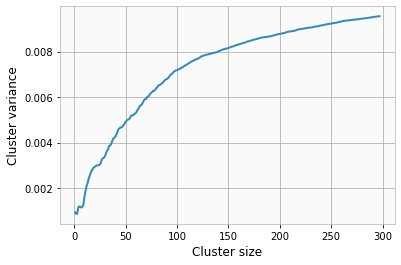

In [41]:
fix, ax = plt.subplots(figsize=(6,4))
plt.plot(var)
plt.xlabel('Cluster size')
plt.ylabel('Cluster variance')
plt.show() 

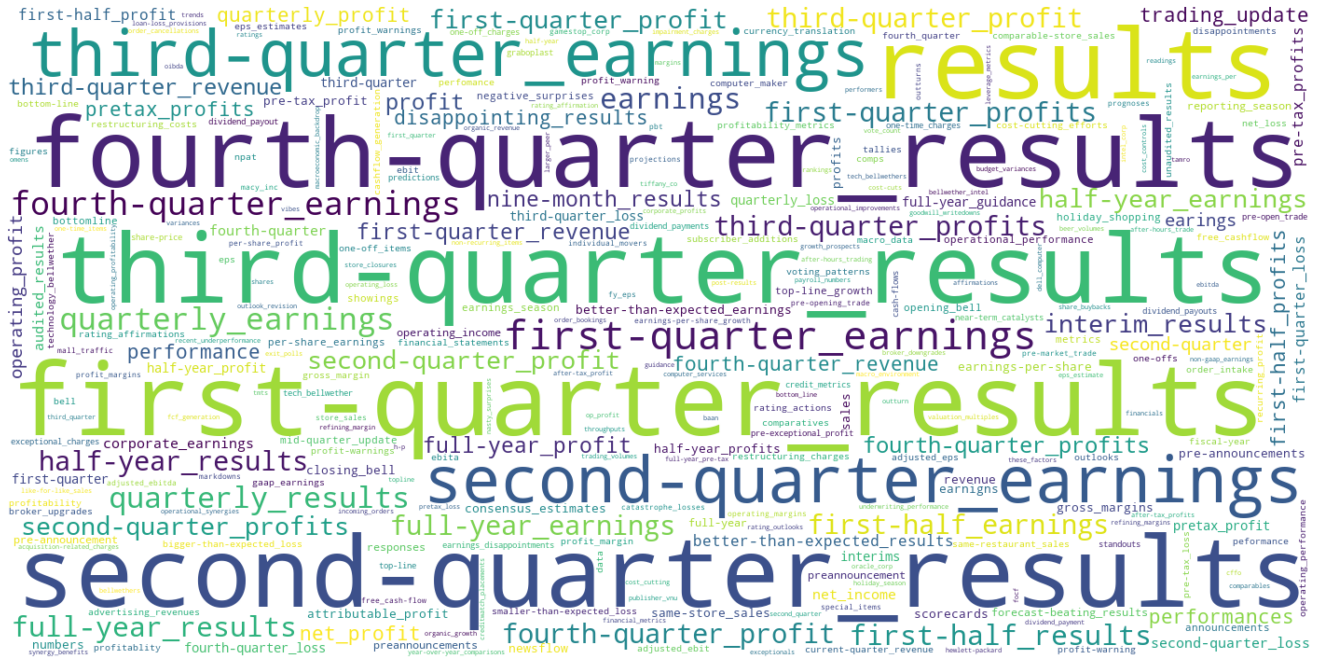

In [42]:
def proj_to_subspace(w, X):
    b = np.linalg.inv(X.T@X) @ (X.T @ w)
    w_dach = X @ b
    return w_dach

topics_dict = {}
for i, w in enumerate(PM.topic):
    v = PM.embeddings_dict[w]
    v_dach = proj_to_subspace(v, X)    
    sim_val = PM.cos_angle(v_dach, v)
    topics_dict[w] = 1/(1+sim_val)
    
    
width, height = 1400, 700
wordcloud = WordCloud(width=width, height=height, max_words=800, relative_scaling=1, normalize_plurals=False, background_color="white")#, mask=mask)
wordcloud = wordcloud.generate_from_frequencies(topics_dict)

plt.figure(figsize=(24,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
#plt.savefig('C:/Users/Stefa/Documents/Uni/Projektassistenz/Auswertung/ProjectionMethod/WordCloud_apple_1_iphone_3.png', dpi=150, facecolor='w', edgecolor='w', orientation='portrait')
plt.show() 

Plane angle: 87.349°


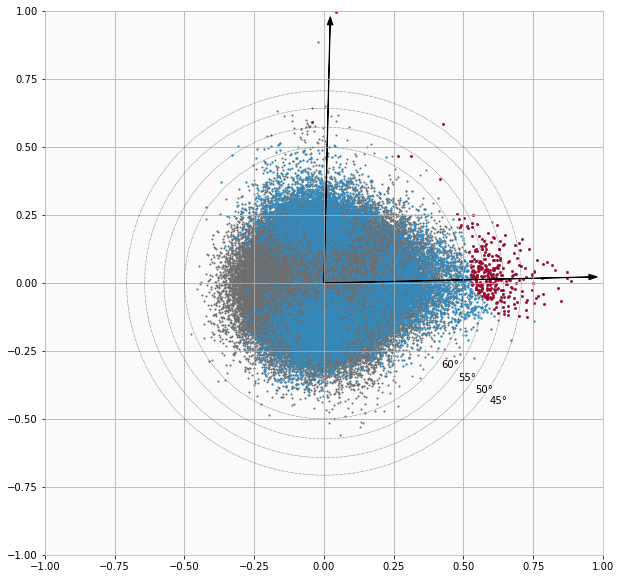

In [39]:
# Project Topic Words and all other words onto the (2d-) plane X
transform = True
gamma = np.arccos(PM.cos_similarity(X[:,0], X[:,1]))
print(f"Plane angle: {round(np.rad2deg(gamma),3)}°")
    
V_df = pd.DataFrame(index = sorted(list(vocab)), 
                    data  = {'vector': [Unitvec(PM.embeddings_dict[w]) for w in sorted(list(vocab))]}).dropna()

bucket_vecs = np.vstack(PM.V_bucket.vector.values).T 
all_vecs    = np.vstack((V_df.loc[~V_df.index.isin(PM.topic+list(PM.V_bucket.index))]).vector.values).T

B_topic  = np.linalg.inv(X.T @ X) @ X.T @ C              # Words contained in the topic
B_bucket = np.linalg.inv(X.T @ X) @ X.T @ bucket_vecs    # Words contained in LSH Bucket
B_vocab  = np.linalg.inv(X.T @ X) @ X.T @ all_vecs       # Remaining Vocab
coord = np.array([[1,0],[0,1]])

x_45 = np.linspace(-np.cos(math.pi/4), np.cos(math.pi/4), 1000)
x_50 = np.linspace(-np.cos(5*math.pi/18), np.cos(5*math.pi/18), 1000)
x_55 = np.linspace(-np.cos(11*math.pi/36), np.cos(11*math.pi/36), 1000)
x_60 = np.linspace(-np.cos(math.pi/3), np.cos(math.pi/3), 1000)
circles = {'45°': np.array([x_45, np.sqrt(np.cos(math.pi/4)**2-x_45**2)]),
           '50°': np.array([x_50, np.sqrt(np.cos(5*math.pi/18)**2-x_50**2)]),
           '55°': np.array([x_55, np.sqrt(np.cos(11*math.pi/36)**2-x_55**2)]),
           '60°': np.array([x_60, np.sqrt(np.cos(math.pi/3)**2-x_60**2)])}
                            
if transform:
    A = np.array([[np.cos((math.pi/2-gamma)/2), np.sin((math.pi/2-gamma)/2)],[np.sin((math.pi/2-gamma)/2), np.cos((math.pi/2-gamma)/2)]])
    B_topic  = A @ B_topic
    B_bucket = A @ B_bucket
    B_vocab  = A @ B_vocab
    coord    = A @ coord

fig, ax = plt.subplots(figsize=(10,10))
ax = plt.scatter(B_vocab[0],  B_vocab[1], c='#6e6e6e', s=2)   
ax = plt.scatter(B_bucket[0], B_bucket[1],c='#348ABD', s=3)   
ax = plt.scatter(B_topic[0],  B_topic[1], c='#A60628', s=5)   
plt.arrow(0,0,0.95*coord[0,0], 0.95*coord[0,1], linewidth=1, color="#000000", head_width=0.02)
plt.arrow(0,0,0.95*coord[1,0], 0.95*coord[1,1], linewidth=1, color="#000000", head_width=0.02)
for c in circles:
    plt.plot(circles[c][0],  circles[c][1], linewidth=0.5, linestyle='dotted', color="#000000")
    plt.plot(circles[c][0], -circles[c][1], linewidth=0.5, linestyle='dotted', color="#000000")   
    plt.text(circles[c][0,-100]*1.05, -circles[c][1,-100]*1.05, c)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

In [ ]:
cluster_df = pd.DataFrame(index = PM.topic, 
                          data  = {'b_topic_x' :B_topic.T[:,0], 
                                   'b_topic_y' :B_topic.T[:,1],
                                   'topic_dist':topics_dict.values()})

bucket_df = pd.DataFrame(index = list(PM.V_bucket.index), 
                        data  = {'b_bucket_x' :B_bucket.T[:,0], 
                                 'b_bucket_y' :B_bucket.T[:,1]})

vocab_df = pd.DataFrame(index = V_df.loc[~V_df.index.isin(PM.topic+list(PM.V_bucket.index))].index, 
                        data  = {'b_vocab_x' :B_vocab.T[:,0], 
                                 'b_vocab_y' :B_vocab.T[:,1]})

output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=0, high=1)
fig = figure(x_axis_label='b1', y_axis_label='b2')
fig.circle('b_vocab_x', 'b_vocab_y',  size=3, alpha=0.3, source=vocab_df, color='#6e6e6e')
fig.circle('b_bucket_x','b_bucket_y', size=3, alpha=0.5, source=bucket_df, color='#1e3d69')
fig.circle('b_topic_x', 'b_topic_y',  size=4, alpha=0.9, source=cluster_df, color={'field': 'topic_dist', 'transform': color_mapper})
fig.x_range=Range1d(-1, 1)
fig.y_range=Range1d(-1, 1)
hover = HoverTool(tooltips=[('token','@index')])
fig.add_tools(hover)

#output_file("bokeh_tfidf_unigram_bigram_10000.html")
#save(fig)
show(fig)

In [ ]:
{k: v for k, v in sorted(topics_dict.items(), reverse=True, key=lambda item: item[1])}

#### 
#### Comparison with cosine similarity method


In [ ]:
def most_similar(seed_words, topn=100):
    """
    Find the most similar words for a list of seed words with cosine similarity.
    If the number of seed_words is > 1, then the weighted mean of those seed vectors is calculated and normalized.
    """        
    V = PM.embeddings_dict[list(vocab)]
    
    mean_v = []
    for seed_w in seed_words:
        weight = seed_w[1]
        mean_v.append(weight*PM.embeddings_dict[seed_w[0]])   
    mean_v   = Unitvec(np.array(mean_v).mean(axis=0))
        
    most_similar_df = pd.DataFrame(index=list(vocab), columns=['cos_sim'])
    most_similar_df['cos_sim'] = V @ mean_v
    most_similar_df = most_similar_df.sort_values(by='cos_sim', ascending=False)
    
    most_similar_dict = {}
    for w in most_similar_df.index[:topn]:
        most_similar_dict[w] = most_similar_df.loc[w, 'cos_sim']
        
    return most_similar_dict, most_similar_df


#seed_words = [('mother', 1), ('father', 1)]
seed_words = [('mark_zuckerberg', 1), ('steve_jobs', 1)]
#seed_words = [('carbon_tax', 1), ('carbon_emissions', 1), ('eco-tax', 0.5)]
#seed_words = [('hurricane', 1), ('landslide', 1)]

most_similar_dict, _ = most_similar(seed_words, topn=200)

# PM  ... projection method
# CSM ... cosine similarity method
pd.set_option('display.max_rows', 150)
PM_CSM = list(set(topics_dict.keys()).difference(set(most_similar_dict.keys())))
CSM_PM = list(set(most_similar_dict.keys()).difference(set(topics_dict.keys())))
topic_words_difference = pd.DataFrame(data={'PM-CSM':pd.Series(PM_CSM), 'CSM-PM':pd.Series(CSM_PM)})
topic_words_difference

In [ ]:
width, height = 1400, 700
wordcloud = WordCloud(width=width, height=height, max_words=800, relative_scaling=1, normalize_plurals=False, background_color="white")#, mask=mask)
wordcloud = wordcloud.generate_from_frequencies(most_similar_dict)

plt.figure(figsize=(24,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
#plt.savefig(data_path+'Word Clouds/dim_32_PCA_24_proj/Topic (sell-off, crash) 50,50 k=0,1.png', dpi=150, facecolor='w', edgecolor='w', orientation='portrait')
plt.show()   

In [ ]:
def weighted_seed_words(x):
    words   = x['seed_words'].split(',')
    weights = x['weight'].split(',')
    return [tuple([words[i].strip(), weights[i]]) for i in range(len(words))]
    
seed_data = pd.read_excel(root_dir+'seed_words.xlsx', sheet_name='seed_words_proj_method')   # Load seed words from file
seed_data.seed_words = seed_data.apply(weighted_seed_words, axis=1)
seed_data = seed_data.drop(columns=['weight'])
seed_data = seed_data.set_index('topic_idx')



In [ ]:
for topic_idx in seed_data.index:
    seed_words     = seed_data.loc[topic_idx, 'seed_words']
    proj_subspace  = [tuple([seed_words[i][0]]) for i,_ in enumerate(seed_words) if float(seed_words[i][1]) > 0]
    neg_seed_words = [tuple([seed_words[i][0]]) for i,_ in enumerate(seed_words) if float(seed_words[i][1]) < 0]
    weights_pos    = np.array([float(seed_words[i][1]) for i,_ in enumerate(seed_words) if float(seed_words[i][1]) > 0])
    weights_neg    = np.array([float(seed_words[i][1]) for i,_ in enumerate(seed_words) if float(seed_words[i][1]) < 0])
    
    print(proj_subspace, weights_pos)
    print(neg_seed_words, weights_neg)

In [ ]:
%%time 
file = 'news_data_FX_####_clean'
init           = True
barrier        = 0.7
max_word_contr = 4    # The maximum value one word can contribute to the topic loading 
                      # (one woord can have a small distance to many topic words; cutoff at max_word_contr)

pca_embds_unitv = {}
for key in pca_embds.keys():
    pca_embds_unitv[key] = unitvec(pca_embds[key])
    
embeddings_dict = get_pca_embds(pca_embds_unitv)


class CustomDataloader(object):
    def __init__(self, file_dir, filename='news_data_FX_####_clean', start_year=2016, end_year=2018, chunksize=10000):
        self.dirname      = file_dir
        self.start        = start_year
        self.end          = end_year
        self.filename     = filename
        self.chunksize    = chunksize
        
    def __iter__(self):
        for year in list(np.arange(self.start, self.end)):
            fname = re.sub(r'####', str(year), self.filename)+'.csv'        
            print(f'file: {fname}')
            
            df_obj = pd.read_csv(os.path.join(self.dirname, fname), iterator=True, chunksize=self.chunksize)
            
            for df_chunk in df_obj:
                df_chunk = df_chunk.dropna(subset=['Body']).reset_index(drop=True)
                df_chunk = df_chunk[df_chunk.duplicated(subset='Headline', keep='first') == False]
                df_chunk = df_chunk[['Timestamp', 'Body']]
                yield df_chunk
                

docs = CustomDataloader(file_dir   = 'F:/Sentiment Analysis Files/FX/clean_fx_news/', 
                  filename   = 'news_data_FX_####_clean', 
                  start_year = 2019, 
                  end_year   = 2020, 
                  chunksize  = 50000)


df_chunk = next(iter(docs))   
print(df_chunk.shape)

In [ ]:
# Invetigate news and Topic loadings

def scale(x):
    return x/max(x)
   
barrier      = 0.85
calc_weights = True
weights = {}

def calc_topic_loading(x, topic_vectors_dict, max_tokens=500):
    topic_loading = {} 
        
    try:
        T = embeddings_dict[[w for w in x.Body.split()[:max_tokens] if w in vocab]]  # Get embeddings for each word in the article text

        #topic_loading['Timestamp'] = x.Timestamp
        
        for i in range(0, len(topic_vectors_dict)):
            topic_vecs = np.array(topic_vectors_dict[f'Topic_{i}'])
            
            if calc_weights:
                X = np.vstack(subspace_vectors_dict[f'Topic_{i}'])
                X = X/norm(X, axis=0)
                B = np.linalg.inv(X.T@X) @ (X.T @ topic_vecs)
                V_proj = X @ B

                norm_v_proj = np.clip(np.sqrt(np.sum(V_proj**2, axis=0)), 0, 1)           # Use clip here to avoid rounding errors
                weights[f'Topic_{i}'] = scale(1/np.clip(np.arccos(norm_v_proj), 0.5, 5))   # This is true if the X vectors are unit vectors (norm_v_proj/1)
                                                                                           # Use of clip: if the angle is < 0.5 -> 1/angle >= 2 -> use lower cutoff of 0.5
            T_cos_sim = T@topic_vecs            
            T_cos_sim[T_cos_sim < barrier] = 0                          # Set all values below the barrier to zero
            T_cos_sim = T_cos_sim*weights[f'Topic_{i}']

            T_cos_sim = T_cos_sim.sum(axis=1)                           # Sum of the cosine similarites between each word in the article with each topic word    
            T_cos_sim[T_cos_sim > max_word_contr] = max_word_contr      # Cut-off values at max_word_contr

            topic_loading[f'Topic_{i}'] = np.sum(T_cos_sim)
        
    except:
        topic_loading['Timestamp'] = x.Timestamp
        for i in range(0, len(topic_vectors_dict)):
            topic_loading[f'Topic_{i}'] = np.nan
                
    return topic_loading


i = 131
print(df_chunk.loc[i, 'Body'])
#calc_topic_loading(df_chunk.loc[4], topic_vectors_dict=topic_vectors_dict)

d = calc_topic_loading(df_chunk.loc[i], topic_vectors_dict=topic_vectors_dict)
sorted(d.items(), key=lambda x: x[1], reverse=True)  

#  
**Visualize Projection Method**  

dim(X) = 64 x 2  
dim(V) = 64 x m  

n_obs = 64  
n_features = 2  

In this case, the observations are the number of vector dimensions, 
the features are the number of words that span X

In [ ]:
pos_seed = [('mother', 1), ('father', 1)]

proj_subspace  = [pos_seed[i][0] for i,_ in enumerate(pos_seed)]
pos_weights    = np.array([pos_seed[i][1] for i,_ in enumerate(pos_seed)])        

topic = [pos_seed[i][0] for i,_ in enumerate(pos_seed) if pos_seed[i][1] > 0]
  

for i, w in enumerate(proj_subspace):           
    a = PM.embeddings_dict[w].reshape(-1,1)
    A = a if i == 0 else np.hstack((A, a))
    

X = A.copy()

v = PM.embeddings_dict['daughter'].reshape(-1,1)
v3d = np.hstack([A, v])

C = np.hstack([A, v])

A = np.hstack([A, np.zeros(64).reshape(-1,1)])

B = np.linalg.inv(X.T@X) @ X.T @ v

x = np.linspace(-.4, .4, 5)
y = np.linspace(-.4, .4, 5)
xx, yy = np.meshgrid(x, y)
z = (B[0][0] * xx + B[1][0] * yy)

In [ ]:
B

In [ ]:
X_hist   = []
RSS_hist = []
B_hist   = []
z_hist   = []

x = np.linspace(-.4, .4, 5)
y = np.linspace(-.4, .4, 5)
xx, yy = np.meshgrid(x, y)

def func(a, W_orth, I, X, C, weights):
    global X_new, X_hist, RSS_hist, v, xx, yy
    
    X_new = X + W_orth @ np.diag(a)
    
    B = np.linalg.inv(X_new.T@X_new) @ X_new.T @ v
    X_hist.append(X_new)
    B_hist.append(B)
    z_hist.append(B[0][0] * xx + B[1][0] * yy)
    
    H_A   = X_new @ np.linalg.inv(X_new.T @ X_new) @ X_new.T
    RSS   = np.sum((((I-H_A) @ C) @ np.diag(weights))**2)
    RSS_hist.append(RSS)
    return RSS    


v_dach = (X@B).flatten()
v_orth = v.flatten()-v_dach

W_orth = np.array([v_orth.T]*X.shape[1]).T         
I = np.identity(X.shape[0]) 
weights = np.array([1,1,1])
result  = optimize.minimize(func, [0]*X.shape[1], method="CG", args=(W_orth, I, X, C, weights))   # Optimize
X_new   = PM.UnitColumns(X_new)   

X_new = np.hstack([X_new, np.zeros(64).reshape(-1,1)])

In [ ]:
A_df = pd.DataFrame(data=A, columns=['x', 'y', 'z'])
v_df = pd.DataFrame(data=v3d, columns=['x', 'y', 'z'])

A_df['type'] = 'X'
v_df['type'] = 'v'

df = pd.concat([A_df, v_df])

mycolorscale = [[0, '#5b5b5b'],
                [1, '#5b5b5b']]


fig = px.scatter_3d(df, x='x', y='y', z='z', color='type', text=None, height=700)

plane = fig.add_surface(x=np.linspace(-.4, .4, 5), y=np.linspace(-.4, .4, 5), z=z, colorscale=mycolorscale, showscale=False, opacity=0.5)

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                              color='DarkSlateGrey')),
                              selector=dict(mode='markers'))
fig.show()

**Animate Optimization**

In [ ]:
import plotly.graph_objects as go
import ipywidgets as widgets
from plotly.offline import init_notebook_mode, plot
init_notebook_mode()

In [ ]:
v3d_hist = []

for i, Xi in enumerate(X_hist):
    #v3d = np.hstack([Xi, v])
    X = np.hstack([Xi, np.zeros(64).reshape(-1,1)])
    
    df0 = pd.DataFrame(data=C, columns=['x', 'y', 'z'])
    df1 = pd.DataFrame(data=X, columns=['x', 'y', 'z'])
    #df2 = pd.DataFrame(data=v3d, columns=['x', 'y', 'z'])
    df0['type'] = 'C'
    df1['type'] = 'X'
    #df2['type'] = 'v'
    
    df = pd.concat([df0, df1])
    df['frame'] = i
    if i == 0:      
        df_hist = df.copy()
    else:
        df_hist = pd.concat([df_hist, df])


In [ ]:
z_hist[-1]

In [ ]:
fig = px.scatter_3d(df_hist, x='x', y='y', z='z', color='type', text=None, height=700, animation_frame='frame')

plane = fig.add_surface(x=np.linspace(-.4, .4, 5), y=np.linspace(-.4, .4, 5), z=z_hist[-1], colorscale=mycolorscale, showscale=False, opacity=0.5)

fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 25
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 10

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                              color='DarkSlateGrey')),
                              selector=dict(mode='markers'))
fig.show()